In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import rasterio as rio
import geopandas as gp

import fiona 
import rasterio
import rasterio.mask

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

from rasterio.mask import mask
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib.lines import Line2D      
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm

import matplotlib.pyplot as plt
from collections import OrderedDict 

from osgeo import gdal, osr, ogr
from tqdm import tqdm


In [2]:
# Helper 

def plot_basemaps(image, shp, title = None, cmap = 'viridis', ax = None, latlabels = True, lonlabels = True, vmax = None):
    imextent = gp.read_file(shp).set_crs("EPSG:4326").to_crs(4326).total_bounds
    shape_feature = ShapelyFeature(Reader("../shape/sierra_catchments.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='white', facecolor = 'none')

    minx, miny, maxx, maxy = imextent
    lllon, lllat = minx, miny
    urlon, urlat = maxx, maxy

    # Create a Stamen Terrain instance.
    stamen_terrain = cimgt.Stamen('terrain-background')

    # Create a GeoAxes in the tile's projection.
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels= False
    gl.right_labels = False
    if not latlabels:
        gl.left_labels = False
    if not lonlabels:
        gl.bottom_labels = False
    
    gl.xlocator = mticker.FixedLocator([-122,-121,-120,-119])
    gl.ylocator = mticker.FixedLocator(np.linspace(0,90,91))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8, 'color': 'gray', 'rotation': 45}
    gl.ylabel_style = {'size': 9, 'color': 'gray'}

    # Limit the extent of the map to a small longitude/latitude range.
    ax.set_extent([lllon, urlon, lllat, urlat])

    # Add the Stamen data at zoom level 8.
    ax.add_image(stamen_terrain, 8)
    
    im = ax.imshow(image,
        cmap=cmap, zorder=1, vmin = 0, vmax = vmax,
        origin="upper", alpha = 0.8,
        extent=(lllon, urlon, lllat, urlat),
        transform=ccrs.PlateCarree(),
    )

    # Add shapefile outline
    ax.add_feature(shape_feature, zorder = 2)
    
    # Set the title
    ax.set_title("{}".format(title), size = 12)
    
    cbar = plt.colorbar(mappable=im,orientation='vertical', fraction=0.05, pad = 0.0125, ax = ax)

    return im


In [3]:
# plot results for entire timeseries 

In [4]:
# 1. mask shapfiles
# 2. merge
# 3. summary plots

In [5]:
# read files setup dirs 
gdf = gp.read_file("../shape/sierra_catchments.shp")

stids_all = list(gdf['stid'].values)
nodata_stids = ["MCR", "CFW"]

stids = [x for x in stids_all if x not in nodata_stids]

# Define outdirs
results_dir = "../results/full_time/"
outdir = os.path.join(results_dir,"merged")
clipdir = os.path.join(results_dir,"clipped")

if not os.path.exists(outdir):
    os.mkdir(outdir)
    
    
if not os.path.exists(clipdir):
    os.mkdir(clipdir)

# Set the vars we have
prcp_vars = ['lag','cor','mi']
smlt_vars = ['lag','cor','mi']

In [6]:
# Clip by watershed into the "../results/full_time/clipped" dir

for stn_id in stids[:]:
    
    print("****" * 15)
    print("PROCESSING : {}".format(stn_id))
    print("****" * 15)

    # get shapefile 
    catch_shp = os.path.abspath("../shape/{}.shp".format(stn_id))
    
    # Get files matching the wshed 
    wshed_files = [os.path.join(results_dir,x) for x in os.listdir(results_dir) if stn_id in x]
    wshed_files = [os.path.abspath(x) for x in wshed_files]
    
    for fn in wshed_files:
        varfn = os.path.split(fn)[1]
        outfn = os.path.join(clipdir,varfn) 
        if not os.path.exists(outfn):
            cmd = '''gdalwarp -dstnodata -999 -cutline {} -crop_to_cutline {} {}'''.format(catch_shp, fn, outfn)
            os.system(cmd)
    print("DONE ---")

************************************************************
PROCESSING : ENG
************************************************************
DONE ---
************************************************************
PROCESSING : PAR
************************************************************
DONE ---
************************************************************
PROCESSING : MIL
************************************************************
DONE ---
************************************************************
PROCESSING : ISB
************************************************************
DONE ---
************************************************************
PROCESSING : DNP
************************************************************
DONE ---
************************************************************
PROCESSING : NML
************************************************************
DONE ---
************************************************************
PROCESSING : ORO
**********************************

In [7]:
# Merge files 

for stn_id in stids[:1]:
    
    print("****" * 15)
    print("PROCESSING : {}".format(stn_id))
    print("****" * 15)

    # loop through vars 
    for prcp_var, smlt_var in tqdm(zip(prcp_vars[:], smlt_vars[:])):
        prcp_files = [os.path.join(clipdir,x) for x in os.listdir(clipdir) if prcp_var in x and 'prcp' in x]
        smlt_files = [os.path.join(clipdir,x) for x in os.listdir(clipdir) if smlt_var in x and 'smlt' in x]
        
        prcp_files = [os.path.abspath(x) for x in prcp_files]
        smlt_files = [os.path.abspath(x) for x in smlt_files]
        
        # merge and write 
        prcp_merged_fn = os.path.join(outdir,"prcp_{}.tiff".format(prcp_var))
        g_prcp = gdal.Warp(prcp_merged_fn, prcp_files, format="GTiff")
        g_prcp = None # Close file
        print("WROTE {}".format(prcp_merged_fn))

        smlt_merged_fn = os.path.join(outdir,"smlt_{}.tiff".format(smlt_var))
        g_prcp = gdal.Warp(smlt_merged_fn, smlt_files, format="GTiff")
        g_prcp = None # Close file
        print("WROTE {}".format(smlt_merged_fn))


0it [00:00, ?it/s]

************************************************************
PROCESSING : ENG
************************************************************
WROTE ../results/full_time/merged/prcp_lag.tiff


1it [00:00,  4.46it/s]

WROTE ../results/full_time/merged/smlt_lag.tiff
WROTE ../results/full_time/merged/prcp_cor.tiff


2it [00:00,  4.72it/s]

WROTE ../results/full_time/merged/smlt_cor.tiff
WROTE ../results/full_time/merged/prcp_mi.tiff


3it [00:00,  4.69it/s]

WROTE ../results/full_time/merged/smlt_mi.tiff


In [26]:
import rasterio as rio

out_ims = {}

for var_type in ['smlt_lag','smlt_cor','smlt_mi', 'prcp_lag','prcp_cor','prcp_mi']:
    src = rio.open("/Users/aakashahamed/Desktop/snodas_box/results/full_time/merged/{}.tiff".format(var_type))
    arr = src.read(1)
    arr[arr==src.nodata] = np.nan # mask nans 
    if "mi" in var_type:
        arr[arr==0] = np.nan
    out_ims[var_type] = arr

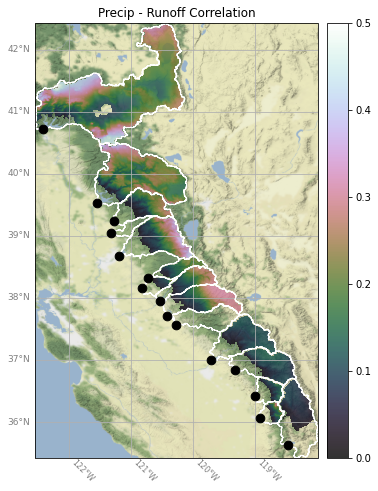

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize = (12,8), subplot_kw={'projection': ccrs.PlateCarree()})
plot_basemaps(out_ims['prcp_cor'], "../shape/sierra_catchments.shp", "Precip - Runoff Correlation", cmap = 'cubehelix', ax = axes, latlabels = True, lonlabels = True, vmax = 0.5)
outlets = gp.read_file("../shape/term_res.shp")
outlets.plot(ax = axes, color = 'black', markersize = 75, edgecolor = 'black', zorder = 4)
plt.show()

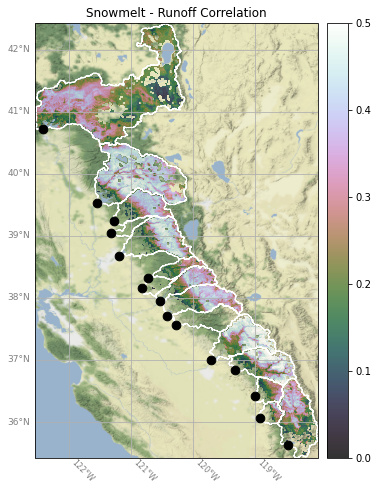

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize = (12,8), subplot_kw={'projection': ccrs.PlateCarree()})
plot_basemaps(out_ims['smlt_cor'], "../shape/sierra_catchments.shp", "Snowmelt - Runoff Correlation", cmap = 'cubehelix', ax = axes, latlabels = True, lonlabels = True, vmax = 0.5)
outlets = gp.read_file("../shape/term_res.shp")
outlets.plot(ax = axes, color = 'black', markersize = 75, edgecolor = 'black', zorder = 4)
plt.show()

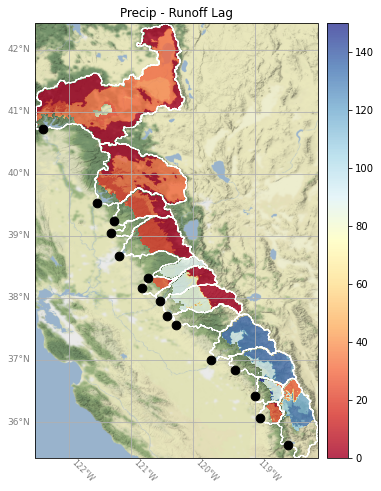

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize = (12,8), subplot_kw={'projection': ccrs.PlateCarree()})
plot_basemaps(out_ims['prcp_lag'], "../shape/sierra_catchments.shp", "Precip - Runoff Lag", cmap = 'RdYlBu', ax = axes, latlabels = True, lonlabels = True, vmax = 150)
outlets = gp.read_file("../shape/term_res.shp")
outlets.plot(ax = axes, color = 'black', markersize = 75, edgecolor = 'black', zorder = 4)
plt.show()

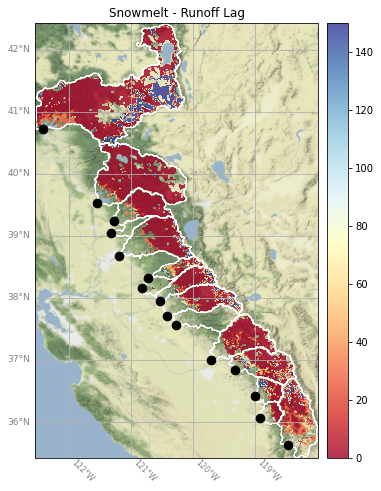

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize = (12,8), subplot_kw={'projection': ccrs.PlateCarree()})
plot_basemaps(out_ims['smlt_lag'], "../shape/sierra_catchments.shp", "Snowmelt - Runoff Lag", cmap = 'RdYlBu', ax = axes, latlabels = True, lonlabels = True, vmax = 150)
outlets = gp.read_file("../shape/term_res.shp")
outlets.plot(ax = axes, color = 'black', markersize = 75, edgecolor = 'black', zorder = 4)
plt.show()

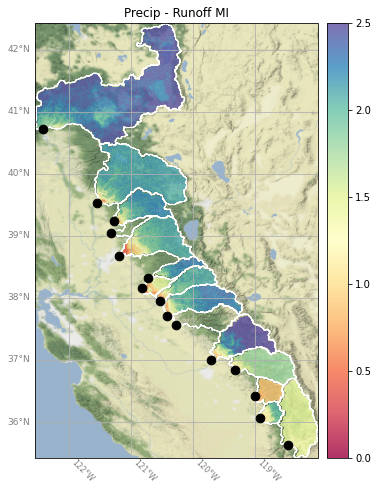

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize = (12,8), subplot_kw={'projection': ccrs.PlateCarree()})
plot_basemaps(out_ims['prcp_mi'], "../shape/sierra_catchments.shp", "Precip - Runoff MI", cmap = 'Spectral', ax = axes, latlabels = True, lonlabels = True, vmax = 2.5)
outlets = gp.read_file("../shape/term_res.shp")
outlets.plot(ax = axes, color = 'black', markersize = 75, edgecolor = 'black', zorder = 4)
plt.show()

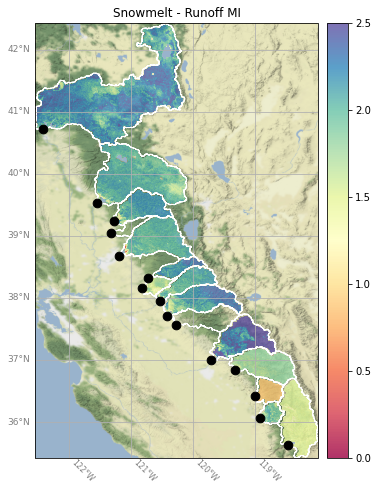

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize = (12,8), subplot_kw={'projection': ccrs.PlateCarree()})
plot_basemaps(out_ims['smlt_mi'], "../shape/sierra_catchments.shp", "Snowmelt - Runoff MI", cmap = 'Spectral', ax = axes, latlabels = True, lonlabels = True, vmax = 2.5)
outlets = gp.read_file("../shape/term_res.shp")
outlets.plot(ax = axes, color = 'black', markersize = 75, edgecolor = 'black', zorder = 4)
plt.show()